# Programming Exercise 5: Regularized Linear Regression and Bias v.s. Variance
*Code's author: Natália Tenório Maia*<br>
*Solution for [Exercise 5](https://www.coursera.org/learn/machine-learning/home/week/6) of Coursera's Machine Learning course by Andrew Ng.*
<br>
<br>
There are many different ways to solve this exercise. Here you will learn just one possible way, where I tried to stick with the original idea proposed in the exercise's pdf.
<br>
<br>
In this exercise, you will implement regularized linear regression and use it to study models with different bias-variance properties.

## Part 1 - Regularized Linear Regression
**Goal:** Use regularized linear regression to predict the amount of water flowing out of a dam using the change of water level in a reservoir. 
<br>
### Importing data

In [1]:
import numpy as np                  # package for scientific computing
import matplotlib.pyplot as plt     # plotting library
from scipy import optimize as opt   # package for optimizing functions
from scipy.io import loadmat        # package for reading MatLab files
import copy                         # package for shallow and deep copy operations

dataset = loadmat('ex5data1.mat')

X = dataset['X']          # input training set
y = dataset['y']          # output training set
Xtest = dataset['Xtest']  # input test set
ytest = dataset['ytest']  # output test set
Xval = dataset['Xval']    # input cross validation set
yval = dataset['yval']    # output cross validation set  

* Training set: it is used to train the ML algorithm, fitting the parameters of the curve to the data;
* Cross validation set: it helps us make a better choice for the regularization parameter;
* Test set: it is used to evaluate the performance of the ML algorithm.

### Visualizing the data

Below, we plot the data for the water flowing out of the dam as a function of the water level measured inside the dam.<br>
OBS: The units in which the flow and to the water level are expressed were not specifed in the exercise sheet.

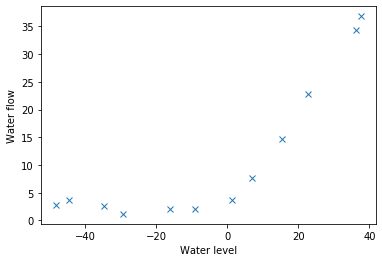

In [2]:
plt.plot(X,y,'x'); plt.xlabel('Water level'); plt.ylabel('Water flow');

### Regularized linear regression cost function and gradient

For linear regression, recall that the regularized cost function and its gradient are given by:
$$J\left(\theta\right)=\frac{1}{2m}\sum_{i=1}^{m}\left(h_{\theta}\left(x_{i}\right)-y_{i}\right)^{2}+\frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{*2},$$ <br>
\begin{align*}
\frac{\partial J\left(\theta\right)}{\partial\theta_{0}} & =\frac{1}{m}\sum_{i=1}^{m}\left[h_{\theta}\left(x^{(i)}\right)-y^{(i)}\right]x_{0}^{(i)},\\
\frac{\partial J\left(\theta\right)}{\partial\theta_{j}} & =\frac{1}{m}\sum_{i=1}^{m}\left[h_{\theta}\left(x^{(i)}\right)-y^{(i)}\right]x_{j}^{(i)}+\frac{\lambda}{m}\theta_{j},
\end{align*}

where $\theta^{*}$, in the cost function, is equal to $\theta$ but excluding the row related to the bias units.

In [3]:
# Simplified matrix multiplication command:
def MM(A,B):
    return np.matmul(A,B)

# Cost function and its gradient:
def costfunction(theta,X,y,lamb):
    theta = theta.reshape(-1,1)   # reshapes theta into a column vector
    m = len(y)                    # number of examples
    h = MM(X,theta)               # hypothesis
    J = (1/(2*m))*np.sum((h-y)**2) + (lamb/(2*m))*np.sum(theta[1:]**2); 
    thetamod = copy.deepcopy(theta); thetamod[0]=0
    #grad = ((1/m)*MM(X.T,h-y) + (lamb/m)*thetamod).flatten()
    grad = ( (1/m)*MM(X.T,(h-y)) + (lamb/m)*thetamod )
    return J , grad

In [4]:
X = dataset['X']; X = np.append(np.ones((len(X),1)),X,axis=1)   # adds bias unit
theta = np.ones((2,1))
lamb = 1
costfunction(theta,X,y,lamb)

(303.9931922202643,
 array([[-15.30301567],
        [598.25074417]]))

The values above agree with what is presented in ex5.pdf.

### Fitting parameters using linear regression using scipy.optimize.minimize

We want to optimize the parameters $\theta$ in order to minimize the cost function $J(\theta)$.

SciPy optimize provides functions for minimizing (or maximizing) objective functions, possibly subject to constraints.<br>
Lib: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

scipy.optimize.minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None) <br>
We will give the following arguments: <br>
* fun: the function costfunction we defined above;
* x0: the array for the initial values of $\theta$ has to be given in the format (n,);
* args: additional variables of the costfunction, which in this case is the training dataset X,y;
* method: the two different optimizing methods which work well for this costfunction are 'TNC' and ’Nelder-Mead’;
* jac: this is True if our cost function provides its gradient, None if not;
* options: we don't have to give options necessarily, but we will limit the maximum number of iterations anyway just to make sure we get the result quickly.



In [5]:
init_theta = np.zeros(X.shape[1]) # the initial theta has to be given as a n-tuple (not a vector) in optmin below.
lamb = 0

optmin = opt.minimize(costfunction,init_theta,(X,y,lamb),jac=True,method='TNC',options={'maxiter': 100})
J = optmin.fun
theta = optmin.x
theta = theta.reshape(-1,1)

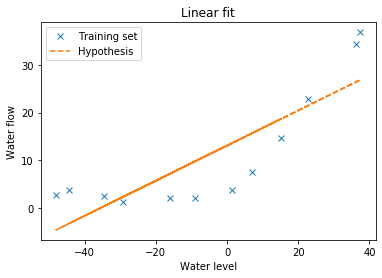

In [6]:
# Hypothesis:
h = MM(X,theta)

# Plotting hypothesis:
plt.plot(X[:,1],y,'x',label='Training set'); plt.xlabel('Water level'); plt.ylabel('Water flow');
plt.plot(X[:,1],h,'--',label='Hypothesis');
plt.legend(); plt.title('Linear fit');

## Part 2: Bias-Variance

An important concept in machine learning is the bias-variance tradeoff. Models with high bias are not complex enough for the data and tend to underfit, while models with high variance overfit to the training data.

**Goal:** In this part of the exercise, you will plot training and test errors on a learning curve to diagnose bias-variance problems.

### Learning curves

You will now implement code to generate the learning curves that will be useful in debugging learning algorithms. Recall that a learning curve plots training and cross validation error as a function of training set size.<br> To plot the learning curve, we need a training and cross validation set error for different *training* set sizes. When you are computing the training set error, make sure you compute it on the training subset instead of the entire training set. However, for the cross validation error, you should compute it over the entire cross validation set.

The **error** is equal to the cost function with the regularization parameter fixed at $\lambda=0$.

In [7]:
def learningcurve(X, y, Xval, yval, lamb, MxIt):
    option = {'maxiter': MxIt}
    Err_tr = np.zeros(len(X))
    Err_val = np.zeros(len(X))
    for i in range(len(X)):
        Xsub = X[:i+1,:]
        ysub = y[:i+1]
        init_theta = np.zeros(X.shape[1])
        optmin = opt.minimize(costfunction,init_theta,(Xsub,ysub,lamb),jac=True,method='TNC',options=option)
        theta = optmin.x
        err_tr = costfunction(theta,Xsub,ysub,0)[0]   # lambda has to be always zero here, by definition.
        err_val = costfunction(theta,Xval,yval,0)[0]  # lambda has to be always zero here, by definition.
        Err_tr[i] = err_tr
        Err_val[i] = err_val
    return Err_tr, Err_val

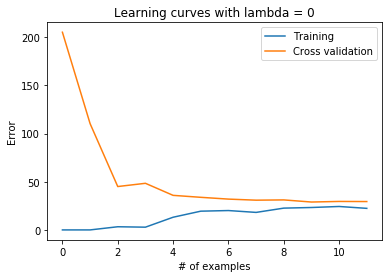

In [8]:
# Calculating Errors:
X = dataset['X']; X = np.append(np.ones((len(X),1)),X,axis=1)                  # assures bias unit
Xval = dataset['Xval']; Xval = np.append(np.ones((len(Xval),1)),Xval,axis=1)   # assures bias unit
lamb = 0
Err_tr, Err_val = learningcurve(X, y, Xval, yval, lamb, 35)

# Plotting:
m = len(y)
plt.plot(range(m),Err_tr,label='Training')
plt.plot(range(m),Err_val,label='Cross validation')
plt.legend(); plt.xlabel('# of examples'); plt.ylabel('Error'); plt.title('Learning curves with lambda = '+str(lamb));

In [9]:
print('Training error related to the largest dataset: '+str(Err_tr[-1]))
print('Validation error related to the largest dataset: '+str(Err_val[-1]))
print('Difference between errors evaluated at the largest dataset: '+str(Err_val[-1]-Err_tr[-1]))

Training error related to the largest dataset: 22.373906495108915
Validation error related to the largest dataset: 29.433818128558997
Difference between errors evaluated at the largest dataset: 7.059911633450081


We can see from the plot above that $Err_{tr}\thickapprox Err_{val}$ as the number of examples increases, and both errors are still high even for the largest dataset. This means the we have a **high bias** problem in our algorithm. If we want to make the erorrs to be smaller, we need to tackle the underfitting problem. We can do that by adding more features to our training set.

## Part 3: Polynomial regression

Now, you will add more features using the higher powers of the existing feature x in the dataset.<br>
**Goal:** Your task is to write a function which maps the original training set X of size m × 1 into its higher powers. Specifically, when a training set X of size m × 1 is passed into the function, the function should return a m×p matrix.

In [10]:
def poly(X,p):
    X_poly = copy.deepcopy(X)
    for i in range(1,p):
        X_poly = np.append(X_poly,X**(i+1),axis=1)
    return X_poly
X = dataset['X']
poly(X,8)[:,7]

array([4.16102047e+09, 5.21751305e+11, 2.94215353e+12, 3.90414759e+12,
       2.84567638e+13, 4.08570215e+07, 3.01509237e+09, 2.10505336e+12,
       1.38676883e+01, 1.50588815e+13, 5.85436023e+06, 7.20771597e+10])

### Learning polynomial regression

Keep in mind that even though we have polynomial terms in our feature vector, we are still solving a linear regression optimization problem. The polynomial terms have simply turned into features that we can use for linear regression.

For this part of the exercise, you will be using a polynomial of degree 8. It turns out that if we run the training directly on the projected data, will not work well as the features would be badly scaled (e.g., an example with x = 40 will now have a feature x8 = 408 = 6.5 × 1012). Therefore, you will need to use feature normalization.

In [11]:
# Feature Normalization function normalizes a matrix A with respect to the values of B of same dimensions:
def FN(A,B):
    M = copy.deepcopy(A)
    for col in range(M.shape[1]):
        for row in range(M.shape[0]):
            val = (M[row,col]-np.mean(B[:,col]))/np.std(B[:,col])
            M[row,col] = val
    return M

In [12]:
X = dataset['X']; Xval = dataset['Xval']; Xtest = dataset['Xtest'] 

# polynomial mapping with feature normalization applied to the different datasets:

X_poly = FN(poly(X,8),poly(X,8))                           # normalizes the polynomial input training set wrt itself             
X_poly = np.append(np.ones((len(X_poly),1)),X_poly,axis=1) # adds bias unit

Xval_poly = FN(poly(Xval,8),poly(X,8))                     # normalizes the polynomial input validation set wrt X 
Xval_poly = np.append(np.ones((len(Xval_poly),1)),Xval_poly,axis=1) 

Xtest_poly = FN(poly(Xtest,8),poly(X,8))                   # normalizes the polynomial input test set wrt X                                  
Xtest_poly = np.append(np.ones((len(Xtest_poly),1)),Xtest_poly,axis=1)

print("Min and max values before normalization:",poly(X,8).min(),poly(X,8).max())
print("Min and max values after normalization:",X_poly.min(),X_poly.max())
print('Normalized Training Example 1:')
X_poly[0, :]

Min and max values before normalization: -592123531634.1227 28456763821657.78
Min and max values after normalization: -2.7633169013168795 2.8890818199263832
Normalized Training Example 1:


array([ 1.        , -0.3782437 , -0.78866232,  0.19032872, -0.7375913 ,
        0.32025197, -0.6171516 ,  0.35983501, -0.53109126])

<font color='red'><b>OBS:</b></font> I should have gotten, according to ex5.m:

array([ 1.        , -0.36214078, -0.75508669,  0.18222588, -0.70618991,
        0.30661792, -0.59087767,  0.3445158 , -0.50848117])
        
The reason why these two normalizations of X are different is because ex5.m uses a normalization that is actually different from the one in ex1.m, which is contrary to what they claim to use. In exercise 1, the feature normalization was done by subtracting the mean value $\mu$ related to each feature of $X$ and dividing by the standard deviation also related to each feature of $X$. The feature normalization used in ex5.m, however, was done by subtracting the mean value $\mu$ related to each feature of $X$ but dividing by the standard deviation related to each feature of X_norm instead, where X_norm, at that point, was equal to $X-\mu$. Both normalizations are valid, but different.

We prefer to stick with the normalization which is done in exercise 1, as this was the original idea proposed in the exercise 5.

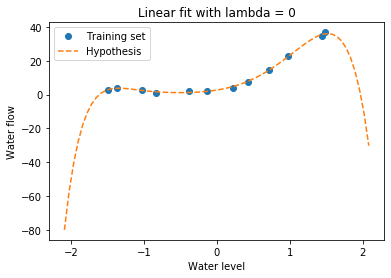

In [13]:
def linearfit(X_poly, y, lamb, MxIt):
    # Fitting parameters:
    option = {'maxiter': MxIt}
    init_theta = np.zeros(X_poly.shape[1])
    optmin = opt.minimize(costfunction,init_theta,(X_poly,y,lamb),jac=True,method='TNC',options = option)
    theta = optmin.x; theta = theta.reshape(-1,1)

    # Plotting:
    Xgrid = np.arange(-65,55,1.785).reshape(-1,1)             # creates a different and larger input set
    Xgrid = FN(poly(Xgrid,8),poly(X,8))                       # maps it into a polynomial format
    Xgrid = np.append(np.ones((len(Xgrid),1)),Xgrid,axis=1)   # adds bias unit
    hgrid = MM(Xgrid,theta)                                   # hypothesis related to this larger input set

    plt.plot(X_poly[:,1],y,'o',label='Training set'); plt.xlabel('Water level'); plt.ylabel('Water flow');
    plt.plot(Xgrid[:,1],hgrid,'--',label='Hypothesis');
    plt.legend(); plt.title('Linear fit with lambda = '+str(lamb));

linearfit(X_poly,y,0,35)

The graph above shows that the parameters fitted by the polynomial linear regression fit very well the trainig set data, but is seems to have a very complex behaviour out of that limit. This is a typical case of **overfitting**. In other words, the fitted parameters that we got are not a good choice to generalize the application of our ML algorithm for water levels that are out of the bounds of the training set. Th

OBS: Although our plot is similar to Figure 4 in ex5.pdf, we should notice that its shape could vary depending on the number of iterations chosen in opt.minimize(). It turns out that for options={'maxiter': 35}, the shape of the plot seems the same as Figure 4, but if we had chosen maxiter equal to 10 or 100, the shape of the plot would be very different. This is not problem, it's just a fact that the shape of the plot depends of the values of the parameters theta, which in turn can vary substantially with the number of iterations chosen in the function opt.minimize().

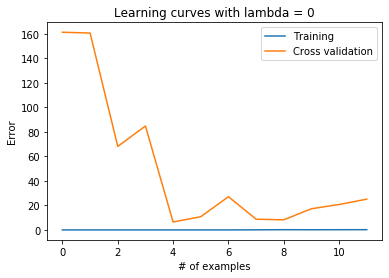

In [14]:
lamb = 0
Err_tr, Err_val = learningcurve(X_poly, y, Xval_poly, yval, lamb, 35)

m = len(y)
plt.plot(range(m),Err_tr,label='Training')
plt.plot(range(m),Err_val,label='Cross validation')
plt.legend(); plt.xlabel('# of examples'); plt.ylabel('Error'); plt.title('Learning curves with lambda = '+str(lamb));

In [15]:
print('Training error related to the largest dataset: '+str(Err_tr[-1]))
print('Validation error related to the largest dataset: '+str(Err_val[-1]))
print('Difference between errors evaluated at the largest dataset: '+str(Err_val[-1]-Err_tr[-1]))

Training error related to the largest dataset: 0.19849969347109633
Validation error related to the largest dataset: 25.14377388275335
Difference between errors evaluated at the largest dataset: 24.945274189282255


We can also identify the overfitting problem by looking at the learning curves above. Notice that the error associated to the training set is approximately zero, and it doesn't change by increasing the number of examples while the error associated with the cross validation set is comparatively very high: $Err_{val} \gg Err_{tr}$ .

One way to combat the overfitting (high-variance) problem is to add regularization to the model. In the next section, you will get to try different λ parameters to see how regularization can lead to a better model.

### Optional (ungraded) exercise: Adjusting the regularization parameter

In this section, you will get to observe how the regularization parameter affects the bias-variance of regularized polynomial regression.

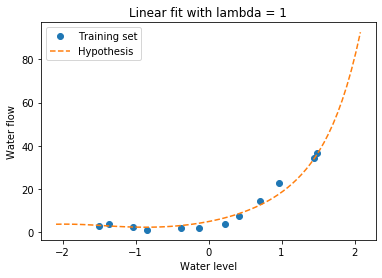

In [16]:
linearfit(X_poly,y,1,35)

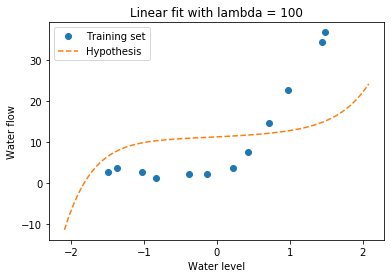

In [17]:
linearfit(X_poly,y,100,35)

Training error related to the largest dataset: 1.9587027523540534
Validation error related to the largest dataset: 4.26321819861629
Difference between errors evaluated at the largest dataset: 2.3045154462622364


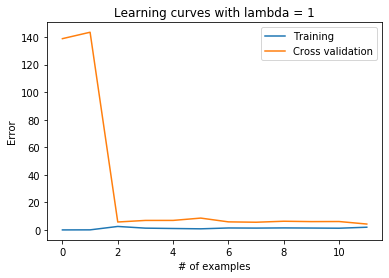

In [18]:
lamb = 1
Err_tr, Err_val = learningcurve(X_poly, y, Xval_poly, yval, lamb, 35)

m = len(y)
plt.plot(range(m),Err_tr,label='Training')
plt.plot(range(m),Err_val,label='Cross validation')
plt.legend(); plt.xlabel('# of examples'); plt.ylabel('Error'); plt.title('Learning curves with lambda = '+str(lamb));

print('Training error related to the largest dataset: '+str(Err_tr[-1]))
print('Validation error related to the largest dataset: '+str(Err_val[-1]))
print('Difference between errors evaluated at the largest dataset: '+str(Err_val[-1]-Err_tr[-1]))

#### Selecting λ using a cross validation set

From the previous parts of the exercise, you observed that the value of λ can significantly affect the results of regularized polynomial regression on the training and cross validation set. In particular, a model without regular- ization (λ = 0) fits the training set well, but does not generalize. Conversely, a model with too much regularization (λ = 100) does not fit the training set and testing set well. A good choice of λ (e.g., λ = 1) can provide a good fit to the data.

In this section, you will implement an automated method to select the λ parameter. Concretely, you will use a cross validation set to evaluate how good each λ value is. After selecting the best λ value using the cross validation set, we can then evaluate the model on the test set to estimate how well the model will perform on actual unseen data.

You should try λ in the following range: {0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10}.

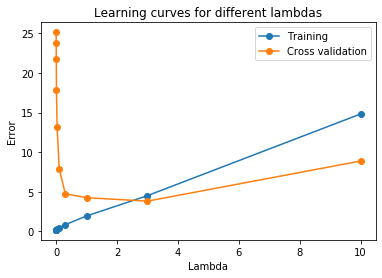

In [19]:
def learningcurve_lamb(X, y, Xval, yval, lamb_list, MxIt):
    option = {'maxiter': MxIt}
    Err_tr = np.zeros(len(lamb_list))
    Err_val = np.zeros(len(lamb_list))
    for i in range(len(lamb_list)):
        lamb = lamb_list[i]
        init_theta = np.zeros(X.shape[1])
        optmin = opt.minimize(costfunction,init_theta,(X,y,lamb),jac=True,method='TNC',options=option)
        theta = optmin.x
        err_tr = costfunction(theta,X,y,0)[0]         # lambda has to be always zero here, by definition.
        err_val = costfunction(theta,Xval,yval,0)[0]  # lambda has to be always zero here, by definition.
        Err_tr[i] = err_tr
        Err_val[i] = err_val
    return Err_tr, Err_val

lamb_list = [0,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10]
Err_tr, Err_val = learningcurve_lamb(X_poly, y, Xval_poly, yval, lamb_list, 35)

plt.plot(lamb_list,Err_tr, '-o',label='Training')
plt.plot(lamb_list,Err_val, '-o',label='Cross validation')
plt.legend(); plt.xlabel('Lambda'); plt.ylabel('Error'); plt.title('Learning curves for different lambdas');

In [20]:
lamb = 3
Err_tr, Err_val = learningcurve(X_poly, y, Xval_poly, yval, lamb, 35)

print('Training error related to the largest dataset: '+str(Err_tr[-1]))
print('Validation error related to the largest dataset: '+str(Err_val[-1]))
print('Difference between errors evaluated at the largest dataset: '+str(Err_val[-1]-Err_tr[-1]))

Training error related to the largest dataset: 4.525117086356662
Validation error related to the largest dataset: 3.8321788747579864
Difference between errors evaluated at the largest dataset: -0.6929382115986757


### Optional (ungraded) exercise: Computing test set error

In the previous part of the exercise, you implemented code to compute the cross validation error for various values of the regularization parameter λ. However, to get a better indication of the model’s performance in the real world, it is important to evaluate the “final” model on a test set that was not used in any part of training (that is, it was neither used to select the λ parameters, nor to learn the model parameters θ).

For this optional (ungraded) exercise, you should compute the test error using the best value of λ you found.

In [21]:
# Fitting parameters with lamb = 3:
lamb = 3
init_theta = np.zeros(X_poly.shape[1])
optmin = opt.minimize(costfunction,init_theta,(X_poly,y,lamb),jac=True,method='TNC',options = {'maxiter': 35})
theta = optmin.x; theta = theta.reshape(-1,1)

# test error:
err_test = costfunction(theta,Xtest_poly,ytest,0)[0]
err_test

3.572041482307915

The value above differs from the value $3.85$ presented in ex5.pdf. This happens because we use a slightly different feature normalization, as mentioned earlier in the begining of Part 3.

### Optional (ungraded) exercise: Plotting learning curves with randomly selected examples

In practice, especially for small training sets, when you plot learning curves to debug your algorithms, it is often helpful to average across multiple sets of randomly selected examples to determine the training error and cross validation error.<br>
Concretely, to determine the training error and cross validation error for i examples, you should first randomly select i examples from the training set and i examples from the cross validation set. You will then learn the parameters θ using the randomly chosen training set and evaluate the parameters θ on the randomly chosen training set and cross validation set. The above steps should then be repeated multiple times (say 50) and the averaged error should be used to determine the training error and cross validation error for i examples.<br>
For this optional (ungraded) exercise, you should implement the above strategy for computing the learning curves.

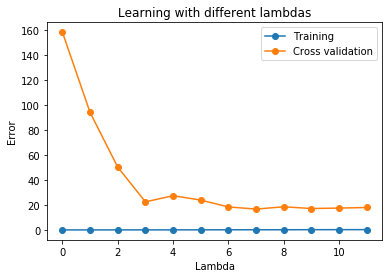

In [22]:
def rand_learningcurve(X,y,Xval,yval,lamb,MxIt,num_repeat):
    init_theta = np.zeros(X.shape[1])
    option = {'maxiter': MxIt}
    Err_tr_mean = np.zeros(len(X))
    Err_val_mean = np.zeros(len(X))
    for i in range(len(X)):
        err_tr_storage = 0
        err_val_storage = 0
        for j in range(num_repeat):   
            rand = np.random.choice(range(len(X)), i+1, replace=False)
            Xsub = X[rand,:]
            ysub = y[rand]       
            optmin = opt.minimize(costfunction,init_theta,(Xsub,ysub,lamb),jac=True,method='TNC',options=option)
            theta = optmin.x
            err_tr = costfunction(theta,Xsub,ysub,0)[0]   # lambda has to be always zero here, by definition.
            err_val = costfunction(theta,Xval,yval,0)[0]  # lambda has to be always zero here, by definition.
            err_tr_storage = err_tr_storage + err_tr
            err_val_storage = err_val_storage + err_val
        Err_tr[i] = err_tr_storage/num_repeat
        Err_val[i] = err_val_storage/num_repeat
    return Err_tr, Err_val

num_repeat = 50
lamb = 0.01
MxIt = 35
Err_tr, Err_val = rand_learningcurve(X_poly,y,Xval_poly,yval,lamb,MxIt,num_repeat)

plt.plot(range(len(X_poly)),Err_tr, '-o',label='Training')
plt.plot(range(len(X_poly)),Err_val, '-o',label='Cross validation')
plt.legend(); plt.xlabel('Lambda'); plt.ylabel('Error'); plt.title('Learning with different lambdas');

The result above looks similar to the one in section 3.5 in ex5.pdf. The plots don't look exactly the same for two reasons: we use different feature normalization and we use random numbers to generate the plots, so they will always be slightly distinct from one another each time we run the cell.

End of exercise 5.